In [1]:
import sys
sys.path.append("../libs/")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import shift_join_data, mae,rmse,mape, plot_pred, plot_history, split_df
from keras.models import load_model

# Carga de datos

In [3]:
df = pd.read_csv('../data/wb_dataset_prep.csv')
df = df.drop('country',axis=1)
iso = df['iso'].unique()    #Codigos de paises
df = df.set_index(['iso','year'])

In [4]:
#df_train, df_test = split_df(df, 0.3)
#df_val = df_test.copy()

In [5]:
print(iso)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'PER'
 'POL' 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2444 entries, ('DEU', 1983) to ('NZL', 2021)
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trade        2444 non-null   float64
 1   exports      2444 non-null   float64
 2   imports      2444 non-null   float64
 3   ggfce        2444 non-null   float64
 4   gfcf         2444 non-null   float64
 5   unempl       2444 non-null   float64
 6   rgdp_growth  2444 non-null   float64
 7   infl_cpi     2444 non-null   float64
 8   oil          2444 non-null   float64
 9   gold         2444 non-null   float64
 10  copper       2444 non-null   float64
 11  sp500        2444 non-null   float64
dtypes: float64(12)
memory usage: 239.0+ KB


# Dividir Datos

In [7]:
iso_test = ['PER']
iso_train = iso[(iso != iso_test[0])]
target_col = ['rgdp_growth']
features = df.columns[(df.columns!=target_col[0])]

In [8]:
print(iso_train)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'POL'
 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


In [9]:
print(features)

Index(['trade', 'exports', 'imports', 'ggfce', 'gfcf', 'unempl', 'infl_cpi',
       'oil', 'gold', 'copper', 'sp500'],
      dtype='object')


In [10]:
_, df_test = split_df(df,1)

# Normalizar

In [11]:
df_x_train = df.loc[iso_train][features].copy()
df_y_train = df.loc[iso_train][target_col].copy()
df_x_test = df_test.loc[iso_test][features].copy()
df_y_test = df_test.loc[iso_test][target_col].copy()

# minmax_scaler_x_train = MinMaxScaler()
# minmax_scaler_y_train = MinMaxScaler()
# minmax_scaler_x_test = MinMaxScaler()
# minmax_scaler_y_test = MinMaxScaler()

std_scaler_x_train = StandardScaler()
std_scaler_y_train = StandardScaler()
std_scaler_x_test = StandardScaler()
std_scaler_y_test = StandardScaler()

# df_x_train.iloc[:,:] = minmax_scaler_x_train.fit_transform(df_x_train)
# df_y_train.iloc[:,:] = minmax_scaler_y_train.fit_transform(df_y_train)
# df_x_test.iloc[:,:] = minmax_scaler_x_test.fit_transform(df_x_test)
# df_y_test.iloc[:,:] = minmax_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = std_scaler_x_train.fit_transform(df_x_train)
df_y_train.iloc[:,:] = std_scaler_y_train.fit_transform(df_y_train)
df_x_test.iloc[:,:] = std_scaler_x_test.fit_transform(df_x_test)
df_y_test.iloc[:,:] = std_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_y_train.iloc[:,:] = np.clip(df_y_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)
df_y_test.iloc[:,:] = np.clip(df_y_test,-5,5)

# Generar variables lag y horizonte

In [12]:
n_steps_in = 10
n_steps_out = 3
n_features = len(features)

x_train, y_train = shift_join_data(df_x_train,df_y_train,iso_train,n_steps_in,n_steps_out)
x_test, y_test = shift_join_data(df_x_test,df_y_test,iso_test,n_steps_in,n_steps_out)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=50,restore_best_weights=True)

In [15]:
n_batch = len(x_train)

In [16]:
n_batch

1695

In [17]:
#mlp = build_mlp(n_steps_in,n_features,n_steps_out,304,4,1e-4,'relu')
model = load_model('ajustes/MLP_20220723_1234.h5')

In [18]:
# from keras import Sequential
# from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, GRU
# from tensorflow.keras.optimizers import Adam

In [19]:
# kernels = 100
# kernel_size = 4
# activation = 'tanh'
# #n_steps_in = 4
# #n_features = 14
# nodes = 150
# #n_steps_out = 3
# learning_rate = 1e-3
# metrics = ['mse']

In [20]:
# model = Sequential()
# model.add(Flatten(input_shape=(n_steps_in, n_features)))
# model.add(Dense(nodes, activation=activation))
# model.add(Dense(nodes, activation=activation))
# model.add(Dense(nodes, activation=activation))
# model.add(Dense(nodes, activation=activation))
# model.add(Dense(nodes, activation=activation))
# model.add(Dropout(0.5))
# model.add(Dense(n_steps_out))
# model.compile(optimizer=Adam(learning_rate=learning_rate),
#                 loss='mse', metrics=metrics)

In [21]:
# kernels = 100
# kernel_size = 4
# activation = 'tanh'
# #n_steps_in = 4
# #n_features = 14
# nodes = 150
# #n_steps_out = 3
# learning_rate = 1e-3
# metrics = ['mse']

In [22]:
# model = Sequential()
# model.add(Conv1D(
#     filters=kernels,
#     kernel_size=kernel_size,
#     activation=activation, 
#     padding='same',
#     input_shape=(n_steps_in, n_features)))
# model.add(MaxPooling1D(pool_size=kernel_size, padding='same'))
# model.add(Dropout(0.2))
# model.add(Conv1D(
#     filters=kernels,
#     kernel_size=kernel_size,
#     activation=activation, 
#     padding='same'))
# model.add(MaxPooling1D(pool_size=kernel_size, padding='same'))
# model.add(Dropout(0.1))
# model.add(Flatten())
# model.add(Dense(nodes, activation=activation))
# model.add(Dense(nodes, activation=activation))
# model.add(Dropout(0.1))
# model.add(Dense(n_steps_out))
# model.compile(optimizer=Adam(learning_rate=learning_rate),
#                 loss='mse', metrics=metrics)

In [23]:
# cells = 150
# activation1 = 'tanh'
# activation2 = 'relu'
# #n_steps_in = 9
# #n_features = 14
# nodes = 150
# layers_lstm=3
# n_steps_out = 3
# learning_rate = 1e-3
# metrics = ['mse']

In [24]:
# #return_sequences = True
# model = Sequential()
# model.add(LSTM(cells, activation=activation1,
#             return_sequences=False, input_shape=(n_steps_in, n_features)))
# #model.add(LSTM(cells, return_sequences=True,activation=activation1))
# #model.add(LSTM(cells, return_sequences=False,activation=activation1))
# #model.add(LSTM(cells, return_sequences=False,activation=activation1))
# model.add(Dropout(0.1))
# model.add(Dense(nodes,activation=activation2))
# model.add(Dense(nodes,activation=activation2))
# model.add(Dropout(0.1))
# model.add(Dense(n_steps_out))
# model.compile(optimizer=Adam(learning_rate=learning_rate),
#                 loss='mse', metrics=metrics)

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 110)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               28416     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 3)                

In [26]:
history = model.fit(x_train,y_train,epochs=2000,batch_size=32,validation_split=0.3,verbose=0,callbacks=[es],shuffle=False)

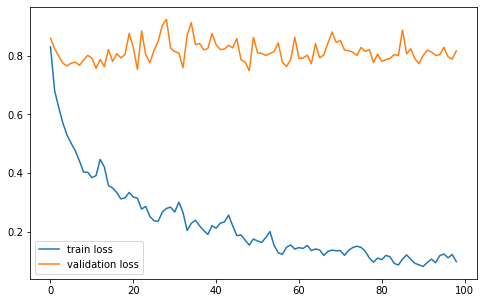

In [27]:
plot_history(history,'loss')

In [28]:
y_pred = model.predict(x_test)

In [29]:
# dn_y_test = minmax_scaler_y_test.inverse_transform(y_test)
# dn_y_pred = minmax_scaler_y_test.inverse_transform(y_pred)

dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)

In [30]:
print(mae(dn_y_test, dn_y_pred))
print(rmse(dn_y_test, dn_y_pred))
print(mape(dn_y_test,dn_y_pred))

[3.7038352  4.00250497 4.03455971]
[5.45422147 5.36137433 5.60320329]
[151.64265364 164.41064223 176.75535308]


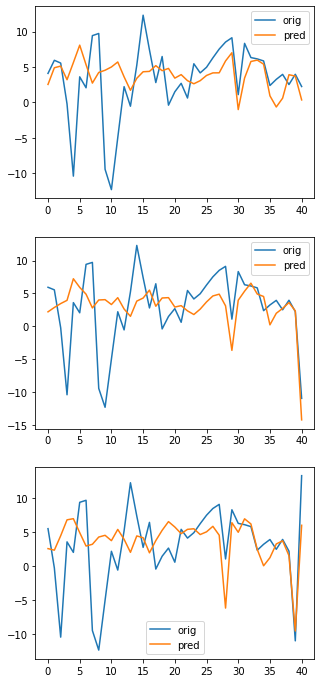

In [31]:
plot_pred(dn_y_test, dn_y_pred)
#plot_pred(y_test, y_pred)